In [1]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# 予測結果の精度確認（ROC曲線の描画）
from sklearn.metrics import roc_auc_score, roc_curve
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
# 特徴量選択
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# 多項式・交互作用特徴量
from sklearn.preprocessing import PolynomialFeatures

In [2]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset, Dataset

In [3]:
class MedcTrainDataset(Dataset):
    def __init__(self):
        super().__init__()
        
        # CSVファイル読み込み（訓練データ）
        df = pd.read_csv('train.csv')
        
        df_x = df.drop(['disease'], axis=1)
        self.df_y = df.loc[:,['disease']]
        
        self.x_desc = df_x.describe()
        self.x_cate , self.x_cont = self.MedcDataChange(df_x)

        self.std_scale = 0
        self.max_scale = 0
        self.dobule_scale = 0
        self.polynomialFlg = 0
        self.DataConv()
        
        self.num = len(self.X_train)

    def __getitem__(self, index):
        return self.X_train[index], self.Y_train[index]
    
    def __len__(self):
        return self.num
    
    def MedcDataChange(self, df_x):
        categ_cols = ['Age','Gender']
        contin_cols = ['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio']

        ####################################
        ##  データ分割
        ##  説明変数と目的変数に分ける。
        ##  説明変数はカテゴリデータと連続データに分ける。
        ####################################
        x_cate = df_x[categ_cols].copy()
        x_cont = df_x[contin_cols].copy()

        ####################################
        ##  カテゴリデータ
        ##  値変換
        ####################################

        # --------------------------------------
        # Ageの変換の変換
        # '0'  ～18歳未満
        # '1'  18歳～25歳未満
        # '2'  25歳～30歳未満
        # '3'  30歳～35歳未満
        # '4'  35歳～40歳未満
        # '5'  40歳～50歳未満
        # '6'  50歳～60歳未満
        # '7'  60歳～70歳未満
        # '8'  70歳～80歳未満
        # '9'  80歳～
        bins = [0, 18, 25, 30, 35, 40, 50, 60, 70, 80 ,1000]
        #X_cut = pd.cut(x_cate['Age'], bins=bins, labels=['Age' + str(x) for x in range(len(bins)-1)])
        X_cut = pd.cut(x_cate['Age'], bins=bins, labels=False)
        cutTemp = np.zeros((len(X_cut), len(bins) -1 ), dtype=int)
        cutTemp[np.arange(len(X_cut)), X_cut.T] = 1
        df_cut=pd.DataFrame(cutTemp ,columns=['Age' + str(x) for x in range(cutTemp.shape[1])])
        # 列の削除
        x_cate.drop(columns=['Age'], inplace=True, axis=1)
        # 列の追加
        x_cate = pd.concat([x_cate, df_cut], axis=1)

        # --------------------------------------
        # 性別を変換する
        colval=['Female','Male']
        # 初期値０の列を作成する
        for col in colval:
            x_cate[col]=0

        # カテゴリ毎に値編集
        for col in colval:
            x_cate.loc[x_cate['Gender']==col, col]=1
        x_cate.drop(columns=['Gender'],inplace=True)

        return x_cate , x_cont

    
    def NpToPy(self):
        
        x_temp = pd.concat([self.x_cate , self.x_cont] , axis=1)
        x_temp = np.array(x_temp)
        y_temp = np.array(self.df_y)
        
        # 訓練データと検証データに分割
        x_train,x_test,y_train,y_test=train_test_split(x_temp, y_temp, test_size=0.2, random_state=1) 
        
        # numpy の値を torch の値に変換する
        self.X_train = torch.from_numpy(x_train).float()
        self.Y_train = torch.from_numpy(y_train).float()
        self.X_test = torch.from_numpy(x_test).float()
        self.Y_test = torch.from_numpy(y_test).float()
        
        self.in_size  = self.X_train.shape[1]
        self.out_size = self.Y_train.shape[1]
        
    def StdScale(self):
        
        if (self.std_scale == 0):

            col='T_Bil'
            std=self.x_desc.loc['std',col]*3
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            self.x_cont.loc[self.x_cont[col]>std , col]=std
            
            col='D_Bil'
            std=self.x_desc.loc['std',col]*3
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            self.x_cont.loc[self.x_cont[col]>std , col]=std

            col='ALP'
            std=self.x_desc.loc['std',col]*3
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            self.x_cont.loc[self.x_cont[col]>std , col]=std

            col='ALT_GPT'
            std=self.x_desc.loc['std',col]*3
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            self.x_cont.loc[self.x_cont[col]>std , col]=std

            col='AST_GOT'
            std=self.x_desc.loc['std',col]*3
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            self.x_cont.loc[self.x_cont[col]>std , col]=std

            col='Alb'
            std=self.x_desc.loc['std',col]*3
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            self.x_cont.loc[self.x_cont[col]>std , col]=std

            col='AG_ratio'
            std=self.x_desc.loc['std',col]*3
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            self.x_cont.loc[self.x_cont[col]>std , col]=std


            col='TP'
            std=5.5
            self.x_cont.loc[self.x_cont[col]<std , col]=std

                        
            
            self.std_scale = 1
            self.NpToPy()
        
    def MaxScale(self):
        
        if (self.max_scale == 0):
            col='T_Bil'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='D_Bil'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='ALP'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='ALT_GPT'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='AST_GOT'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='TP'
            maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval
            self.x_cont.loc[:,col]=1-self.x_cont.loc[:,col]

            col='Alb'
            maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval
            self.x_cont.loc[:,col]=1-self.x_cont.loc[:,col]

            col='AG_ratio'
            maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval
            self.x_cont.loc[:,col]=1-self.x_cont.loc[:,col]

            self.max_scale = 1
            self.NpToPy()

    def DobuleScale(self):
        
        if (self.dobule_scale == 0):
            col='T_Bil'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='D_Bil'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='ALP'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='ALT_GPT'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='AST_GOT'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='TP'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]
            
            col='Alb'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]
            
            col='AG_ratio'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]
            
            self.dobule_scale = 1
            self.NpToPy()
            
    def PolynomialTrance(self):
        if (self.polynomialFlg == 0):
            col1='T_Bil'
            col2='D_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='T_Bil'
            col2='ALP'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='D_Bil'
            col2='ALP'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='ALT_GPT'
            col2='AST_GOT'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='ALT_GPT'
            col2='T_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='ALT_GPT'
            col2='D_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='ALT_GPT'
            col2='ALP'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='AST_GOT'
            col2='T_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='AST_GOT'
            col2='D_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='AST_GOT'
            col2='ALP'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='TP'
            col2='Alb'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='TP'
            col2='AG_ratio'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='Alb'
            col2='AG_ratio'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            self.polynomialFlg = 1
            self.NpToPy()
        
    def snsPlot(self):
        
        # seabornで相関係数を描画
        plt.figure(figsize=(15,15))
        df_sns = pd.concat([self.x_cont , self.df_y] , axis=1)
        sns.heatmap(df_sns.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
        plt.show()
        
    def DataConv(self):
        
        self.StdScale()
        #self.MaxScale()
        #self.PolynomialTrance()
        #self.DobuleScale()
        
        

In [4]:
class MedcTestDataset(MedcTrainDataset):
    def __init__(self, x_desc):
        
        # CSVファイル読み込み（訓練データ）
        df = pd.read_csv('test.csv')

        self.x_desc = x_desc
        self.x_cate , self.x_cont = self.MedcDataChange(df)
        
        self.std_scale = 0
        self.max_scale = 0
        self.dobule_scale = 0
        self.polynomialFlg = 0
        self.DataConv()
        
        self.num = len(self.x_cate)

    def __getitem__(self, index):
        return self.X_test[index]
    
    def __len__(self):
        return self.num
    
    def NpToPy(self):
        
        x_temp = pd.concat([self.x_cate , self.x_cont] , axis=1)
        x_temp = np.array(x_temp)
        
        # numpy の値を torch の値に変換する
        self.X_vat = torch.from_numpy(x_temp).float()

    def snsPlot(self):
        
        # seabornで相関係数を描画
        plt.figure(figsize=(15,15))
        df_sns = self.x_cont
        sns.heatmap(df_sns.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
        plt.show()

## 訓練データの読み込み

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


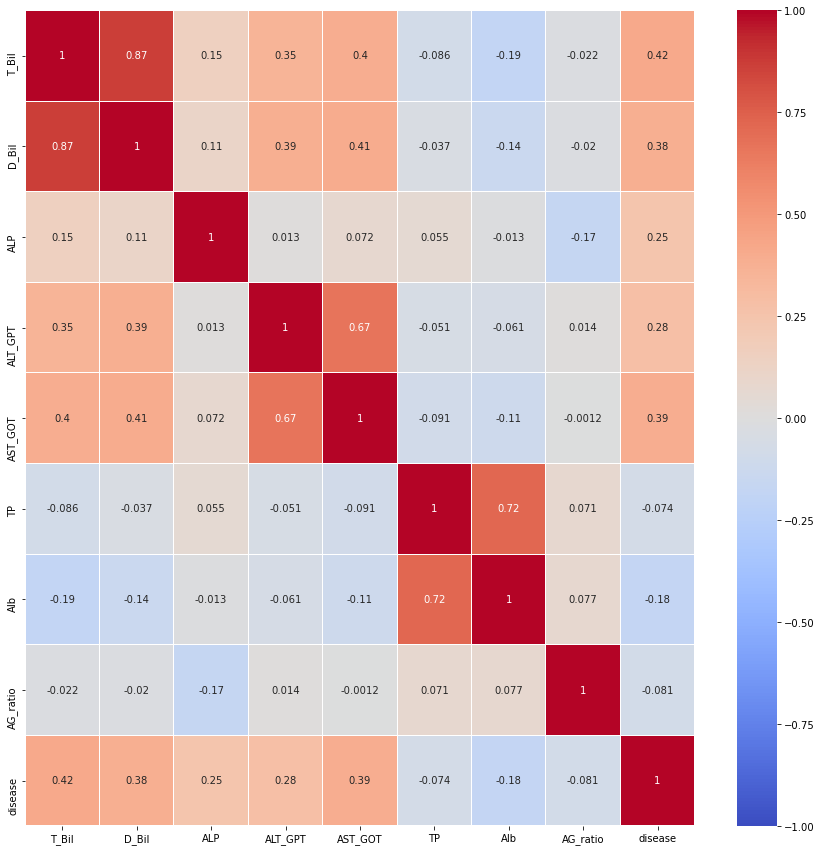

In [5]:
train_dataset = MedcTrainDataset()
total_samples = len(train_dataset)
train_dataset.snsPlot()

In [6]:
train_dataset.x_cont.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,1.444906,0.512869,254.856554,30.181127,51.582240,7.042263,3.517458,0.680588
std,1.666917,0.924298,95.040383,55.999565,62.964310,0.819913,0.559942,0.003250
min,0.585961,0.034861,163.261838,3.924518,11.283497,5.500000,2.180884,0.627133
25%,0.781258,0.144889,213.991414,13.644658,21.239157,6.730612,3.139153,0.680825
50%,0.835591,0.194085,220.092503,16.638001,27.056026,6.915580,3.621339,0.680825
75%,1.196759,0.335447,229.455927,23.056081,56.461568,7.536151,3.712524,0.680825
max,7.314605,4.614812,598.474019,370.984154,327.287931,8.739000,5.016970,0.680825


In [7]:
print(train_dataset.in_size)
print(train_dataset.out_size)

20
1


## 評価データの読み込み

In [8]:
test_dataset = MedcTestDataset(train_dataset.x_desc)

In [9]:
test_dataset.x_cont.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,1.366948,0.456659,247.174368,28.456219,49.180742,7.096556,3.561579,0.676818
std,1.496998,0.856401,62.492275,51.447851,59.586223,0.863600,0.607376,0.000432
min,0.610073,0.053853,175.747532,7.862773,11.278741,5.500000,2.296308,0.668751
25%,0.787081,0.147714,214.211425,13.551174,20.842910,6.725417,3.128234,0.676841
50%,0.845039,0.193881,220.738618,16.449139,25.971274,6.931101,3.620933,0.676841
75%,0.973743,0.236440,231.839764,22.760056,52.746083,7.553500,3.738682,0.676841
max,6.822959,4.671090,384.406534,361.417106,284.304483,8.752045,5.009589,0.676841


In [21]:
batchsize=50

# batch_size ：学習する時にまとめるデータ数
# shuffle    : データをランダムに並び替える場合はTrue
#train_loader = DataLoader(train ,batch_size=30, shuffle=True, num_workers=2)
train_loader = DataLoader(dataset=train_dataset ,batch_size=batchsize, shuffle=True)

In [22]:
node1=40
node2=10


# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net ,self).__init__()
        # ドロップアウト
        p=0.2
        self.dropout1 = nn.Dropout(p)
        self.dropout2 = nn.Dropout(p)
        # 全結合層
        self.fc1 = nn.Linear(train_dataset.in_size , node1)         # nn.Linear (入力のノード数 , 中間層ノード数)
        self.fc2 = nn.Linear(node1 , node2)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc3 = nn.Linear(node2,  2)        # nn.Linear (中間層ノード数 , 出力のノード数)
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x):
#        x = torch.relu(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
#        x = F.sigmoid(self.fc2(x))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        x = torch.sigmoid (self.fc1(x))           # 入力のノードを中間層（１階層目）に渡して結果を得る
        #x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))           # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        #x = self.dropout2(x)
        x = self.fc3(x)           # 中間層（２階層目）の結果を出力層に渡す
        return F.log_softmax(x , dim=0)
        #return x

In [23]:
# モデルの定義
model = Net()
# 損失の定義 (平均二乗誤差)
criterion = nn.MSELoss()
# 損失の定義 (平均二乗誤差)
#criterion = nn.BCELoss()
# 損失の定義 (交差エントロピー誤差関数)
#criterion = nn.CrossEntropyLoss()

In [24]:
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
## model.parameters  調整する値
## lr(learning rate) ：学習率　どれぐらいの幅でパラメータを更新していくのか
optimizer = optim.Adam(model.parameters() , lr=0.005)
#optimizer = optim.SGD(model.parameters() , lr=0.01)

In [25]:
import math

loss_list = []
loss_temp = 0
logdisp=1
accuracy_list = []

correct_counter = 0
acccnt=len(train_dataset)*logdisp
epochs=50


# トレーニングの回数分ループする。
for epoch in range(epochs):
    # 損失を初期化　
    total_loss = 0
    
    for x_train , y_train in train_loader:

        # 出力を計算する 
        output = model(x_train)
        
        #  one-hot vector に変換します。
        Y_ohv = torch.zeros(2 * y_train.shape[0] ,dtype=torch.float32).reshape(y_train.shape[0], 2 )
        for i in range(y_train.shape[0]):    
            Y_ohv[i, y_train[i].numpy()] = 1.0 # one-hot vector
            
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss = criterion(output ,Y_ohv)

        #correct_temp = (y_train == torch.max(output ,1)[1]).sum()
        correct_temp = (y_train == torch.max(output ,axis=1)[1].reshape(-1,1)).sum()
        correct_counter += correct_temp

        # パラメータの勾配を初期化する
        optimizer.zero_grad()
        # ロスを伝播する
        loss.backward()
        # パラメータを更新する
        optimizer.step()

        # トータルロスを格納
        total_loss += loss.item()
        
    
    
    # 回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_tmp=total_loss/acccnt
        print(f'Epoch\t{epoch+1}\t\tLoss\t{loss_tmp:.8f}\t\taccuracy:\t{(correct_counter*100)/acccnt:.3f}%')
        
        accuracy_list.append(correct_counter.item()*100/(acccnt))
        loss_list.append(loss_tmp)
        loss_temp=0
        total_loss=0
        correct_counter = 0
        

Epoch	1		Loss	0.39948751		accuracy:	70.000%
Epoch	2		Loss	0.39934964		accuracy:	78.000%
Epoch	3		Loss	0.39927208		accuracy:	79.000%
Epoch	4		Loss	0.39927751		accuracy:	79.000%
Epoch	5		Loss	0.39926995		accuracy:	80.000%
Epoch	6		Loss	0.39925980		accuracy:	80.000%
Epoch	7		Loss	0.39926931		accuracy:	80.000%
Epoch	8		Loss	0.39924570		accuracy:	80.000%
Epoch	9		Loss	0.39927121		accuracy:	80.000%
Epoch	10		Loss	0.39924936		accuracy:	80.000%
Epoch	11		Loss	0.39923891		accuracy:	82.000%
Epoch	12		Loss	0.39926240		accuracy:	79.000%
Epoch	13		Loss	0.39927815		accuracy:	80.000%
Epoch	14		Loss	0.39925208		accuracy:	78.000%
Epoch	15		Loss	0.39926181		accuracy:	80.000%
Epoch	16		Loss	0.39924039		accuracy:	81.000%
Epoch	17		Loss	0.39921681		accuracy:	83.000%
Epoch	18		Loss	0.39921494		accuracy:	82.000%
Epoch	19		Loss	0.39922329		accuracy:	82.000%
Epoch	20		Loss	0.39921652		accuracy:	81.000%
Epoch	21		Loss	0.39922399		accuracy:	82.000%
Epoch	22		Loss	0.39920336		accuracy:	82.000%
Epoch	23		Loss	0.39

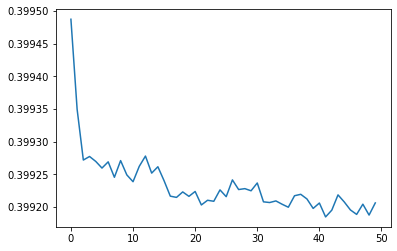

In [26]:
# ロスのプロット
plt.plot(loss_list)

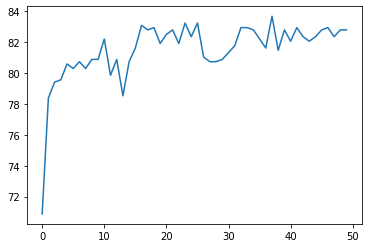

In [27]:
plt.plot(accuracy_list)

## 誤差の確認

In [85]:
#print(Y_test)

In [86]:
# 学習を行わないモードに変更
model.eval()



y_hat=model(train_dataset.X_test).data
y_hat=y_hat.round().numpy()
#y_hat=torch.max(y_hat ,1)[1]
y_true=train_dataset.Y_test.numpy()
accuracy = np.sum(y_true == y_hat) /len(y_true)
print(accuracy)


0.8294117647058824


## ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）

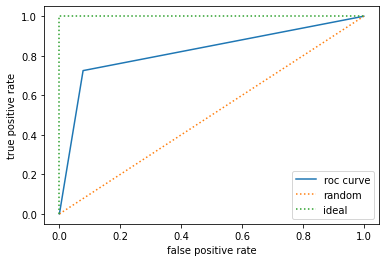

[2. 1. 0.]


In [87]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_hat)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
print(thresholds)

In [88]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_true, y_score=y_hat)
print("AUC:", auc_score)

AUC: 0.8236111111111112


#  予測する

In [89]:
y_predict = model(test_dataset.X_vat).data
print(y_predict)
y_predict = y_predict.round().numpy()
df_out = pd.DataFrame(np.array(y_predict ,dtype=np.int32), columns=['val'])

df_out.to_csv('./submit.csv', encoding='utf_8_sig' , header=False)


tensor([[ 0.0452],
        [ 0.1137],
        [ 0.0232],
        [ 0.0206],
        [ 0.2044],
        [ 0.0198],
        [ 0.9037],
        [ 0.5045],
        [ 0.0767],
        [ 0.1675],
        [ 0.0683],
        [ 0.0306],
        [ 0.4337],
        [ 1.0154],
        [ 0.0282],
        [ 0.0050],
        [ 0.7436],
        [ 0.0646],
        [ 0.0993],
        [ 0.0231],
        [ 0.3940],
        [ 0.0187],
        [ 0.0369],
        [ 0.2334],
        [ 0.1108],
        [ 0.0151],
        [ 0.3273],
        [ 0.7108],
        [ 0.1833],
        [ 0.9761],
        [ 0.2933],
        [ 0.6848],
        [ 0.1239],
        [ 0.2120],
        [ 0.7718],
        [ 0.8858],
        [ 0.0185],
        [ 0.2719],
        [ 0.0586],
        [ 0.8329],
        [ 0.6726],
        [ 0.6593],
        [ 0.7434],
        [ 0.1585],
        [ 0.2519],
        [ 0.3576],
        [ 0.0252],
        [ 0.8012],
        [ 0.0109],
        [ 0.2110],
        [ 0.5546],
        [ 0.6258],
        [ 1.

# モデルの保存

In [249]:
#model_path = 'model.pth'
#torch.save(model.to('cpu').state_dict(), model_path)